In [220]:
# Basics
import pandas as pd
import numpy  as np
from umap import UMAP
import numpy  as np

Plotting

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sns.set_theme(style="ticks")

ML

In [227]:
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

random_state = 42

Load data

In [223]:
wine = pd.read_csv("winequality-red.csv")

wine_X = wine.loc[:,"fixed acidity":"alcohol"]
wine_y = wine.quality

X_train, X_test, y_train, y_test = train_test_split(
    wine_X, wine_y,
    random_state=random_state)

EDA

<AxesSubplot:xlabel='quality', ylabel='Count'>

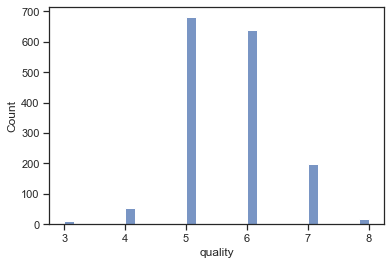

In [224]:
sns.histplot(
    data=wine_y
)

C:\tools\miniconda3\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


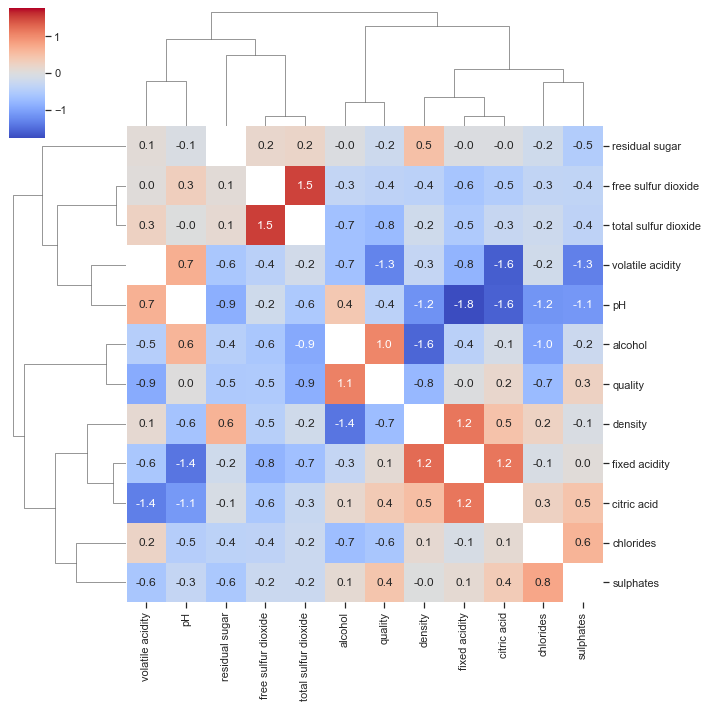

In [225]:
mask = np.identity(12)
sns.clustermap(
    wine.corr(),
    metric="correlation",
    annot=True,
    mask=mask,
    fmt="1.1f",
    square=True,
    z_score=1,
    cmap="coolwarm",
    norm=colors.CenteredNorm(),
    col_cluster=True
    )

Train Classifier

In [240]:
regressors = {
    "knn": KNeighborsRegressor(
        weights="distance",
        n_neighbors=50
    ),
    "gpr": GaussianProcessRegressor(),
    "rfr": RandomForestRegressor()
}

In [241]:
scaler = RobustScaler(
    with_centering=True,
    unit_variance=True
)

reducer = LinearDiscriminantAnalysis(
    n_components=2
)

reg_comp = StackingRegressor(
    estimators=regressors,
    final_estimator=LinearSVR()
)

pipeline = make_pipeline(
    scaler, reg_comp
    # scaler, reducer, regressor
    # scaler, mapper, reducer, regressor
)

pipeline.fit(X=X_train, y=y_train)
pred = pipeline.predict(X=X_test)#.round()

print("Score: " f"{pipeline.score(X_test, y_test):.2}")
print("MSE: " f"{mean_squared_error(y_test, pred):.2}")

ValueError: too many values to unpack (expected 2)

In [244]:
reg_comp.fit(wine_X, wine_y)

ValueError: too many values to unpack (expected 2)

<AxesSubplot:xlabel='quality'>

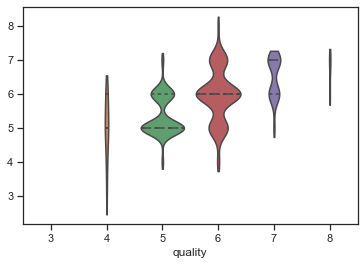

In [ ]:
sns.violinplot(
    x=y_test, 
    y=pred, 
    cbar=True, 
    palette="deep", 
    cut=1,
    inner="quartile",
    scale="count"
    )

In [ ]:
mapper = UMAP(
    n_components=10,
    # densmap=True,
    metric="l2",
    # output_metric="correlation",
    target_metric="l2",
    n_neighbors=20,
    target_weight=0.5,
    min_dist=0,
    unique=True,
    random_state=random_state
)

embedding = mapper.fit_transform(
    X=scaler.fit_transform(wine_X),
    y=wine_y
)

<AxesSubplot:>

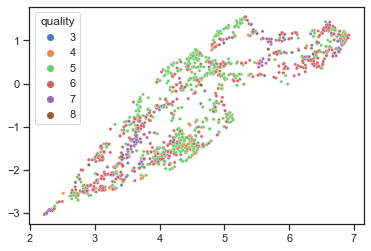

In [ ]:
sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    hue=wine_y,
    s=10,
    palette="muted"
)

In [ ]:
pipeline["lineardiscriminantanalysis"].explained_variance_ratio_

array([0.85540101, 0.09115006])

In [ ]:
pipeline

Pipeline(steps=[('robustscaler', RobustScaler(unit_variance=True)),
                ('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(n_components=2)),
                ('gaussiannb', GaussianNB())])